In [ ]:
import pandas as pd
import numpy as np
file_path = "/content/NGAsub_MegaFlatfile_RotD50_050_R211022_public.xlsx"
df = pd.read_excel(file_path)

In [ ]:
df.rename(columns={
    'PGA_g': 'pga',
    'Earthquake_Magnitude': 'mag',
    'Rjb_km': 'rjb',
    'Hypocenter_Depth_km': 'hypd',
    'Vs30_Selected_for_Analysis_m_s': 'vs30',
    'Intra_Inter_Flag': 'intra_inter',
    'Sensor_Depth_m': 'sensor_depth',
    'Multiple_Event': 'multi_event',
    'Late_P_trigger_flag_1ptYes_0ptNo': 'late_flag',
    'Source_review_flag': 'src_flag',
    'Longest_Usable_Period_for_PSa_Ave_Component_sec': 'tgm',
    'NGAsubEQID': 'eid'
}, inplace=True)

In [ ]:
df = df[(df['pga'] != -999) & (df['pga'] <= 10) & (df['mag'] >= 4)]

meta_cols = ['mag', 'rjb', 'hypd', 'vs30',"Ztor_km"]
for col in meta_cols:
    df = df[df[col] != -999]

df = df[df['intra_inter'].isin([0, 1, 5])]

is_interface = (df['intra_inter'] == 0) & (df['hypd'] < 40)
is_intraslab = (df['intra_inter'] == 1) & (df['hypd'] < 200)
df = df[is_interface | is_intraslab]

df = df[df['rjb'] <= 1000]

df = df[df['sensor_depth'] <= 2]

df = df[df['multi_event'] != 1]

df = df[df['late_flag'] != 1]

df = df[df['src_flag'].isin([0, 1, 2, 4])]

df = df[df['tgm'] >= 10]

event_counts = df['eid'].value_counts()
valid_eids = event_counts[event_counts >= 3].index
df = df[df['eid'].isin(valid_eids)]
df.shape

(14526, 227)

In [ ]:
df.drop_duplicates()
df.shape

(14526, 227)

In [ ]:
df.Geomatrix_Site_Code_1st_Letter.unique()

array(['-999', 'C'], dtype=object)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import r2_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# ========== Data Preprocessing ==========
# df = pd.read_excel('your_file.xlsx')  # Load your data

df['logrjb'] = np.log10(df['rjb'].replace(0, 0.01))
df['logvs30'] = np.log10(df['vs30'].astype(float).replace(0, 0.01))

input_features = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter']

output_cols = [col for col in df.columns if col.startswith(tuple([
    "T0pt", "T1pt", "T2pt", "T3pt", "T4pt", "T5pt", "T6pt", "T7pt", "T8pt", "T9pt", "T10pt", "T11pt", "T12pt", "T13pt", "T14pt", "T15pt", "T20pt"
]))]
df[output_cols] = df[output_cols].clip(lower=1e-6)
df[output_cols] = np.log10(df[output_cols])

X = df[input_features]
y = df[output_cols].values

# One-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[['intra_inter']])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(['intra_inter']))

X = X.drop(columns=['intra_inter'])
X = pd.concat([X.reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)
X = X.values

# Split and scale
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ========== Autoencoder Function ==========
def build_autoencoder(input_dim, bottleneck_dim=3):
    # Encoder
    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(x)
    encoder = Model(inputs=input_layer, outputs=bottleneck)

    # Decoder
    encoded_input = Input(shape=(bottleneck_dim,))
    y = Dense(32, activation='relu')(encoded_input)
    y = Dense(64, activation='relu')(y)
    output_layer = Dense(y_train.shape[1], activation='linear')(y)
    decoder = Model(inputs=encoded_input, outputs=output_layer)

    # Autoencoder = Decoder(Encoder(input))
    auto_output = decoder(encoder(input_layer))
    autoencoder = Model(inputs=input_layer, outputs=auto_output)

    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

# ========== Training Loop ==========
n_runs = 10
r2_scores = []
bottleneck_all = []

for run in range(n_runs):
    tf.keras.backend.clear_session()
    np.random.seed(run)
    tf.random.set_seed(run)

    autoencoder, encoder = build_autoencoder(X_train.shape[1])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    autoencoder.fit(X_train, y_train, validation_split=0.2,
                    epochs= 100, batch_size=16, verbose=0,
                    callbacks=[early_stop])

    # Prediction & R²
    y_pred = autoencoder.predict(X_test, verbose=0)
    r2 = r2_score(y_test, y_pred)

    r2_scores.append(r2)

    # Extract bottleneck
    bottleneck_vals = encoder.predict(X_train, verbose=0)
    bottleneck_all.append(bottleneck_vals)



# ========== Results ==========
r2_scores = np.array(r2_scores)
print(f"\nAverage R² over {n_runs} runs: {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")

avg_bottleneck = np.mean(np.stack(bottleneck_all), axis=0)
pca_means = np.mean(avg_bottleneck, axis=0)

print("\nAverage bottleneck components across training samples:")
for i, val in enumerate(pca_means):
    print(f"PCA {i+1} (mean): {val:.6f}")



Average R² over 10 runs: 0.8676 ± 0.0033

Average bottleneck components across training samples:
PCA 1 (mean): -0.022259
PCA 2 (mean): -0.013496
PCA 3 (mean): -0.303241


In [ ]:
import plotly.graph_objs as go
import numpy as np

# Extract NLPCA components for X_test
tf.keras.backend.clear_session()
np.random.seed(0)
tf.random.set_seed(0)

# Build fresh encoder from scratch (same structure)
autoencoder, encoder = build_autoencoder(X_train.shape[1])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
autoencoder.fit(X_train, y_train, validation_split=0.2,
                epochs=100, batch_size=16, verbose=0,
                callbacks=[early_stop])

# Get NLPCA (bottleneck) components for X_test
X_test_nlpca = encoder.predict(X_test, verbose=0)

# Earthquake Magnitude for coloring
_, X_test_orig_df, _, _ = train_test_split(df[input_features], y, test_size=0.2, random_state=42)
magnitudes = X_test_orig_df['mag'].values

# Interactive 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=X_test_nlpca[:, 0],
    y=X_test_nlpca[:, 1],
    z=X_test_nlpca[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        color=magnitudes,  # Color by earthquake magnitude
        colorscale='Viridis',
        opacity=0.8,
        colorbar=dict(title='Magnitude')
    ),
    text=[f"Magnitude: {mag:.2f}" for mag in magnitudes],  # Tooltip text
)])

fig.update_layout(
    title="Interactive 3D Plot of NLPCA Components (Test Set)",
    scene=dict(
        xaxis_title='NLPCA Component 1',
        yaxis_title='NLPCA Component 2',
        zaxis_title='NLPCA Component 3'
    ),
    margin=dict(l=0, r=0, b=0, t=30),
    height=600
)

fig.show()


#Basic Plots


1a- Magnitude vs Joyner-Boore distance

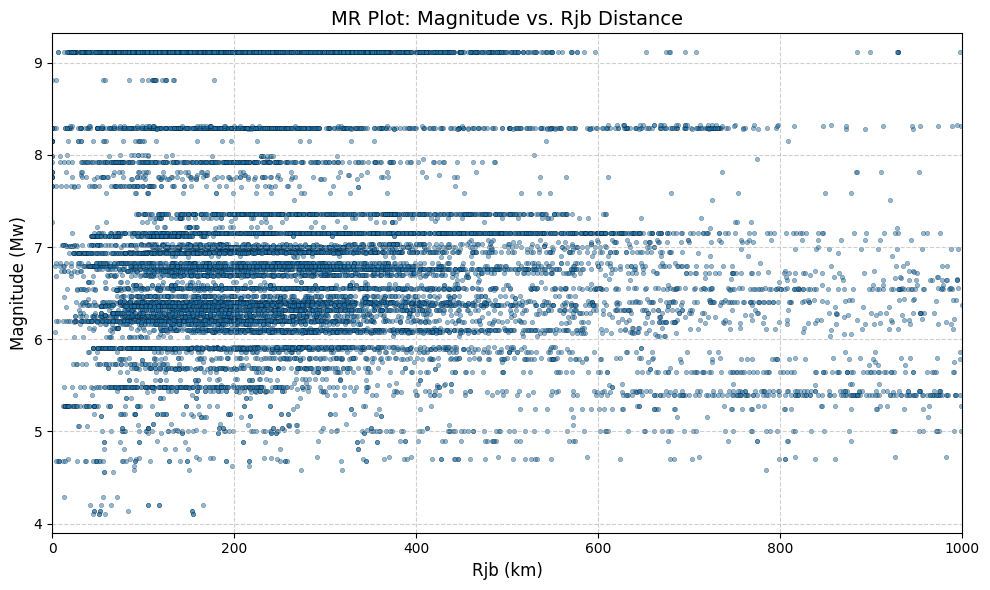

In [ ]:
import matplotlib.pyplot as plt

# Ensure 'mag' and 'rjb' are in the DataFrame
plt.figure(figsize=(10, 6))
plt.scatter(df['rjb'], df['mag'], s=10, alpha=0.5, edgecolors='k', linewidths=0.3)

plt.xlabel('Rjb (km)', fontsize=12)
plt.ylabel('Magnitude (Mw)', fontsize=12)
plt.title('MR Plot: Magnitude vs. Rjb Distance', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, 1000)
plt.ylim(df['mag'].min() - 0.2, df['mag'].max() + 0.2)
plt.tight_layout()
plt.show()

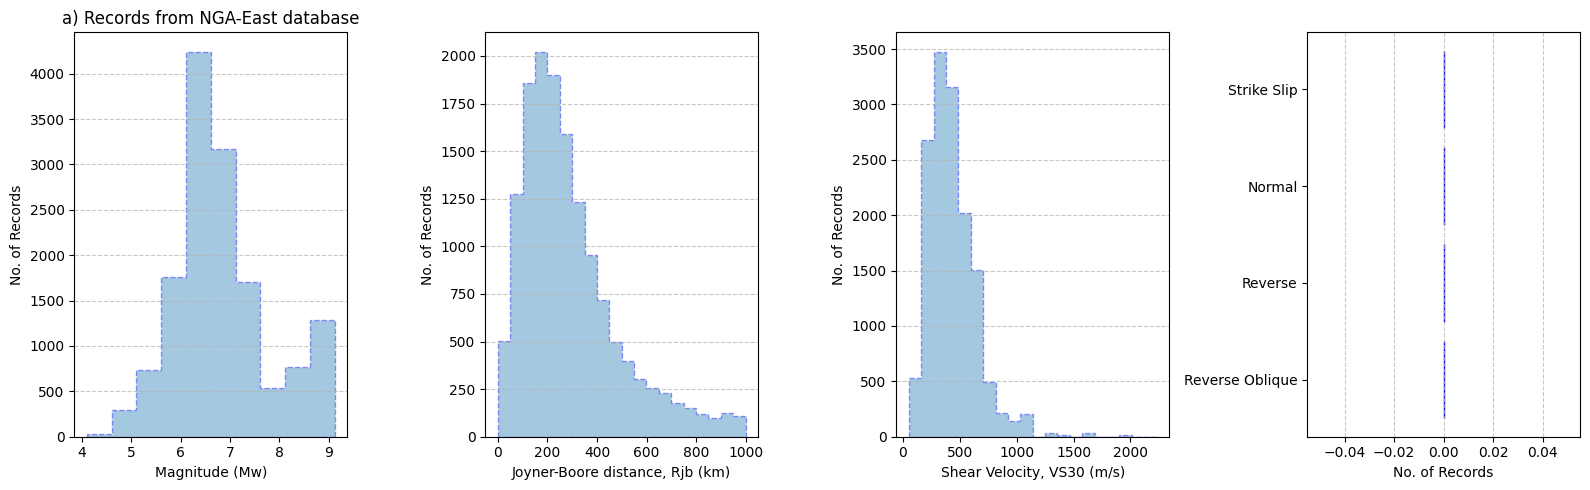

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 4, figsize=(16, 5))

# 1. Histogram for Magnitude (mag)
axs[0].hist(df["mag"], bins=10, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[0].set_xlabel("Magnitude (Mw)")
axs[0].set_ylabel("No. of Records")
axs[0].set_title("a) Records from NGA-East database")
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Histogram for Joyner-Boore Distance (rjb)
axs[1].hist(df["rjb"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[1].set_xlabel("Joyner-Boore distance, Rjb (km)")
axs[1].set_ylabel("No. of Records")
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Histogram for VS30
axs[2].hist(df["vs30"], bins=20, edgecolor='blue', linestyle='--', histtype='stepfilled', alpha=0.4)
axs[2].set_xlabel("Shear Velocity, VS30 (m/s)")
axs[2].set_ylabel("No. of Records")
axs[2].grid(axis='y', linestyle='--', alpha=0.7)


# 3. Horizontal bar plot for Fault_Type
# Clean Fault_Type strings
# Convert 'Fault_Type' to string before applying .str.title()
df["Fault_Type"] = df["Fault_Type"].astype(str).str.title() # Changed to convert to string
fault_order = ["Strike Slip", "Normal", "Reverse", "Reverse Oblique"]
fault_counts = df["Fault_Type"].value_counts().reindex(fault_order, fill_value=0)

axs[3].barh(fault_counts.index, fault_counts.values, color='skyblue', edgecolor='blue', hatch='//')
axs[3].set_xlabel("No. of Records")
axs[3].invert_yaxis()
axs[3].grid(axis='x', linestyle='--', alpha=0.7)

# Layout
plt.tight_layout()
plt.show()

# 2) Network Architecture

In [ ]:
!apt-get install graphviz -y
!pip install pydot


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


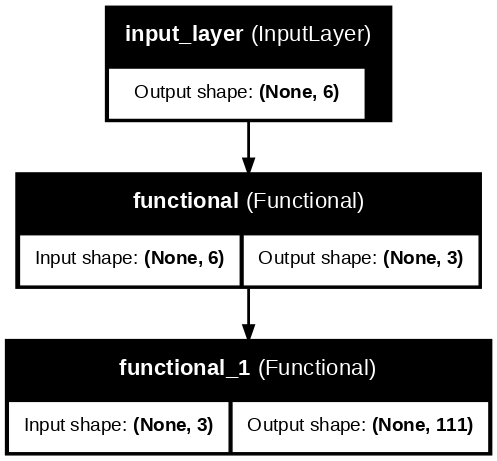

In [ ]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

# Plot and display
plot_model(autoencoder, to_file='autoencoder_model.png', show_shapes=True, show_layer_names=True, dpi=100)
display(Image(filename='autoencoder_model.png'))


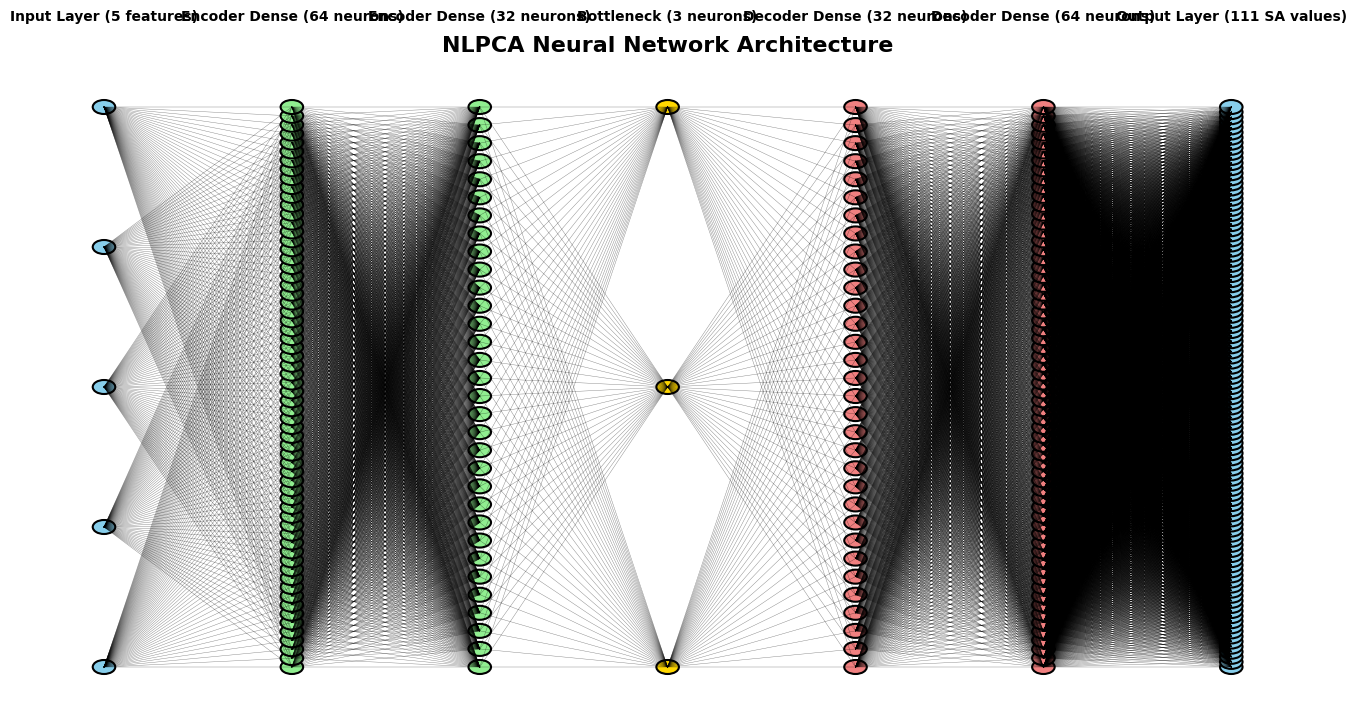

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_network():

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.axis('off')

    # Define layers
    layers = [5, 64, 32, 3, 32, 64, y_train.shape[1]]  # Your architecture

    # X positions of layers
    layer_positions = np.linspace(0, 1, len(layers))

    # Colors
    colors = ['skyblue', 'lightgreen', 'lightgreen', 'gold', 'lightcoral', 'lightcoral', 'skyblue']

    # Draw neurons
    for idx, (x, num_neurons) in enumerate(zip(layer_positions, layers)):
        y_positions = np.linspace(0.1, 0.9, num_neurons)
        for y in y_positions:
            circle = plt.Circle((x, y), 0.01, color=colors[idx], ec='black', lw=1.5)
            ax.add_artist(circle)

    # Draw connections
    for idx in range(len(layers) - 1):
        x_start, x_end = layer_positions[idx], layer_positions[idx + 1]
        y_start = np.linspace(0.1, 0.9, layers[idx])
        y_end = np.linspace(0.1, 0.9, layers[idx + 1])

        for y1 in y_start:
            for y2 in y_end:
                ax.plot([x_start, x_end], [y1, y2], 'k-', lw=0.3, alpha=0.5)

    # Add labels
    layer_labels = [
        'Input Layer (5 features)',
        'Encoder Dense (64 neurons)',
        'Encoder Dense (32 neurons)',
        'Bottleneck (3 neurons)',
        'Decoder Dense (32 neurons)',
        'Decoder Dense (64 neurons)',
        f'Output Layer ({y_train.shape[1]} SA values)'
    ]

    for idx, (x, label) in enumerate(zip(layer_positions, layer_labels)):
        ax.text(x, 1.02, label, ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Title
    plt.title('NLPCA Neural Network Architecture', fontsize=16, fontweight='bold', pad=20)

    plt.show()

draw_network()


#3) Principle Componant (PCA) Plots

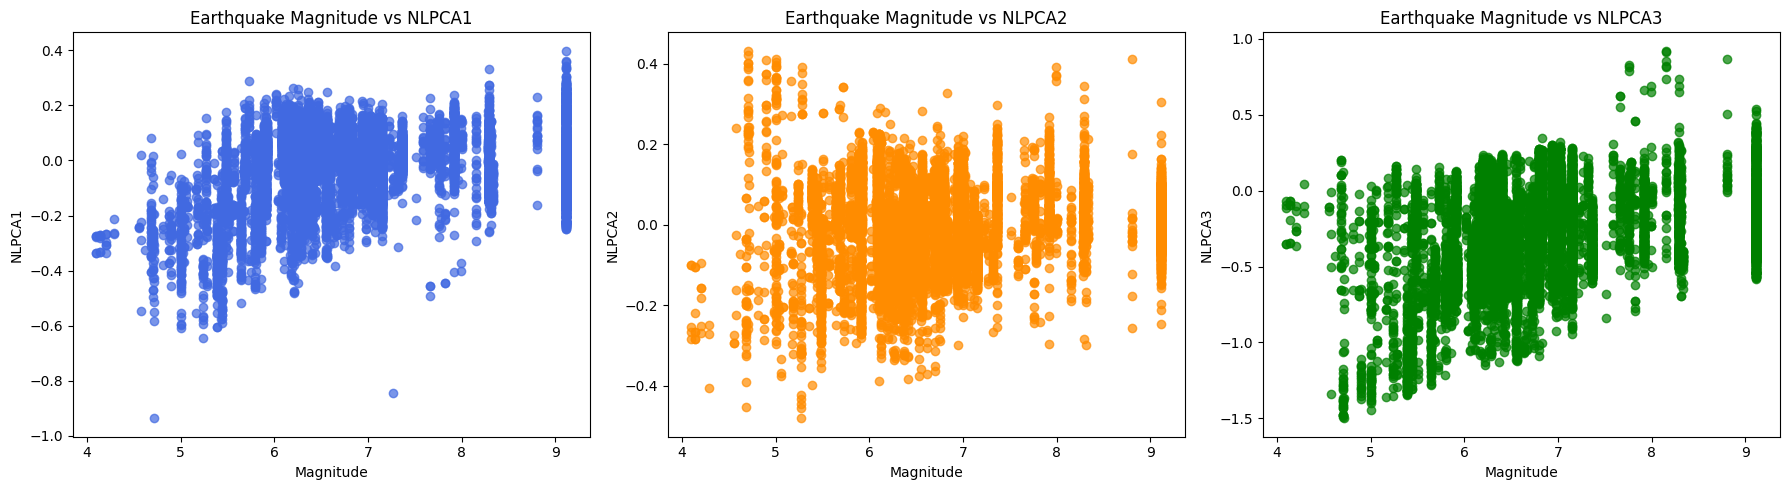

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Split df to get TRAIN SET magnitudes (matching avg_bottleneck)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
magnitudes = df_train['mag'].values  # Now this matches avg_bottleneck rows

# Extract averaged NLPCA components
pca1 = avg_bottleneck[:, 0]
pca2 = avg_bottleneck[:, 1]
pca3 = avg_bottleneck[:, 2]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(magnitudes, pca1, color='royalblue', alpha=0.7)
axs[0].set_title('Earthquake Magnitude vs NLPCA1')
axs[0].set_xlabel('Magnitude')
axs[0].set_ylabel('NLPCA1')

axs[1].scatter(magnitudes, pca2, color='darkorange', alpha=0.7)
axs[1].set_title('Earthquake Magnitude vs NLPCA2')
axs[1].set_xlabel('Magnitude')
axs[1].set_ylabel('NLPCA2')

axs[2].scatter(magnitudes, pca3, color='green', alpha=0.7)
axs[2].set_title('Earthquake Magnitude vs NLPCA3')
axs[2].set_xlabel('Magnitude')
axs[2].set_ylabel('NLPCA3')

plt.tight_layout()
plt.show()


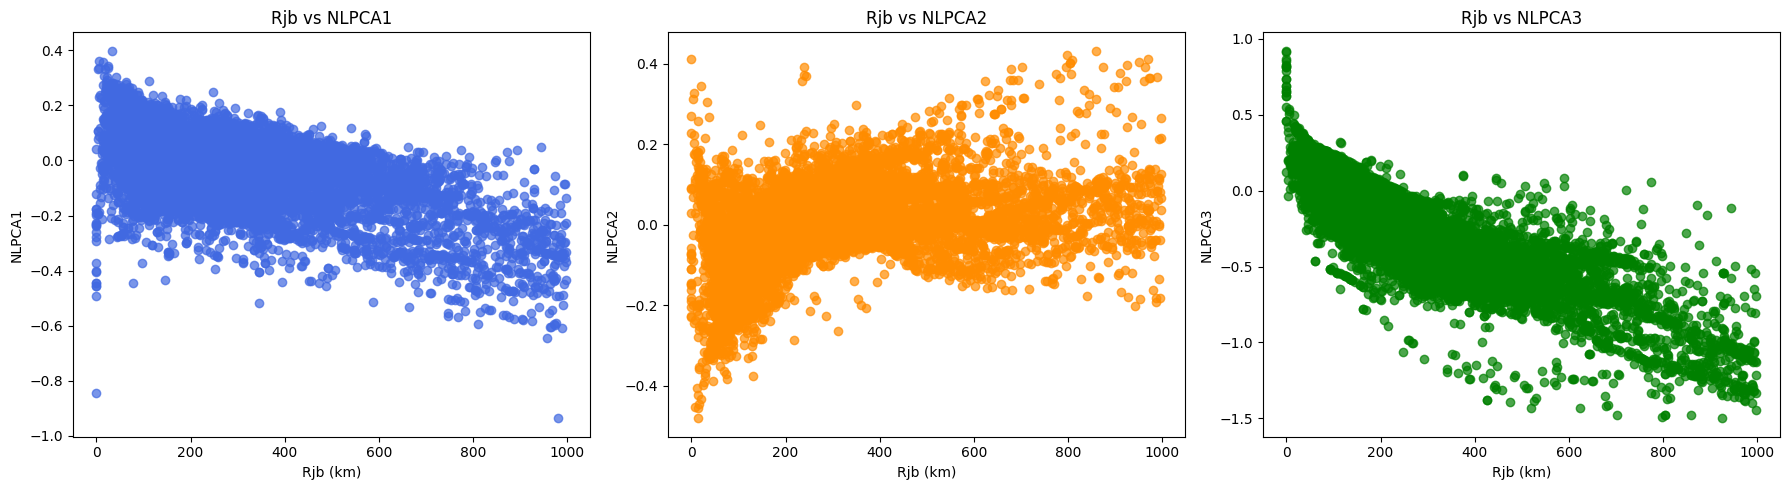

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Get Rjb values matching the TRAIN set (since avg_bottleneck is from training samples)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
rjb = df_train['rjb'].values  # Matches avg_bottleneck rows

# Extract NLPCA components from averaged bottleneck
pca1 = avg_bottleneck[:, 0]
pca2 = avg_bottleneck[:, 1]
pca3 = avg_bottleneck[:, 2]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(rjb, pca1, color='royalblue', alpha=0.7)
axs[0].set_title('Rjb vs NLPCA1')
axs[0].set_xlabel('Rjb (km)')
axs[0].set_ylabel('NLPCA1')

axs[1].scatter(rjb, pca2, color='darkorange', alpha=0.7)
axs[1].set_title('Rjb vs NLPCA2')
axs[1].set_xlabel('Rjb (km)')
axs[1].set_ylabel('NLPCA2')

axs[2].scatter(rjb, pca3, color='green', alpha=0.7)
axs[2].set_title('Rjb vs NLPCA3')
axs[2].set_xlabel('Rjb (km)')
axs[2].set_ylabel('NLPCA3')

plt.tight_layout()
plt.show()


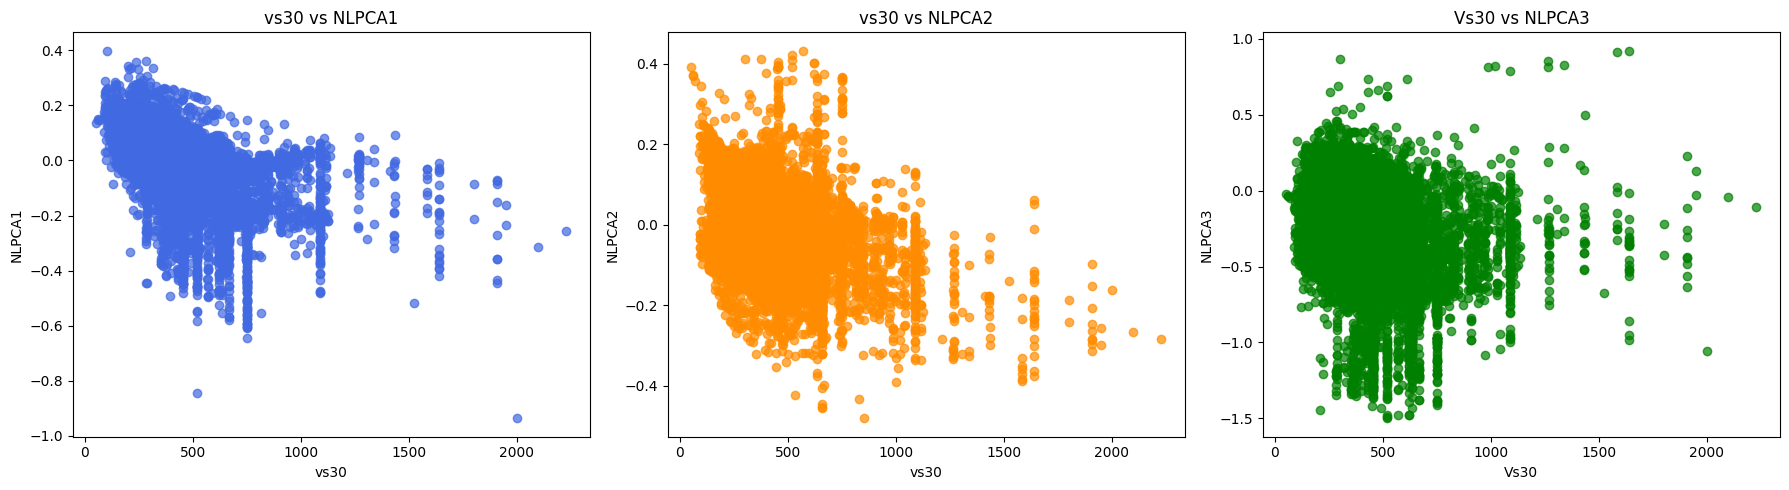

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Get Rjb values matching the TRAIN set (since avg_bottleneck is from training samples)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
rjb = df_train['vs30'].values  # Matches avg_bottleneck rows

# Extract NLPCA components from averaged bottleneck
pca1 = avg_bottleneck[:, 0]
pca2 = avg_bottleneck[:, 1]
pca3 = avg_bottleneck[:, 2]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(rjb, pca1, color='royalblue', alpha=0.7)
axs[0].set_title('vs30 vs NLPCA1')
axs[0].set_xlabel('vs30')
axs[0].set_ylabel('NLPCA1')

axs[1].scatter(rjb, pca2, color='darkorange', alpha=0.7)
axs[1].set_title('vs30 vs NLPCA2')
axs[1].set_xlabel('vs30')
axs[1].set_ylabel('NLPCA2')

axs[2].scatter(rjb, pca3, color='green', alpha=0.7)
axs[2].set_title('Vs30 vs NLPCA3')
axs[2].set_xlabel('Vs30')
axs[2].set_ylabel('NLPCA3')

plt.tight_layout()
plt.show()

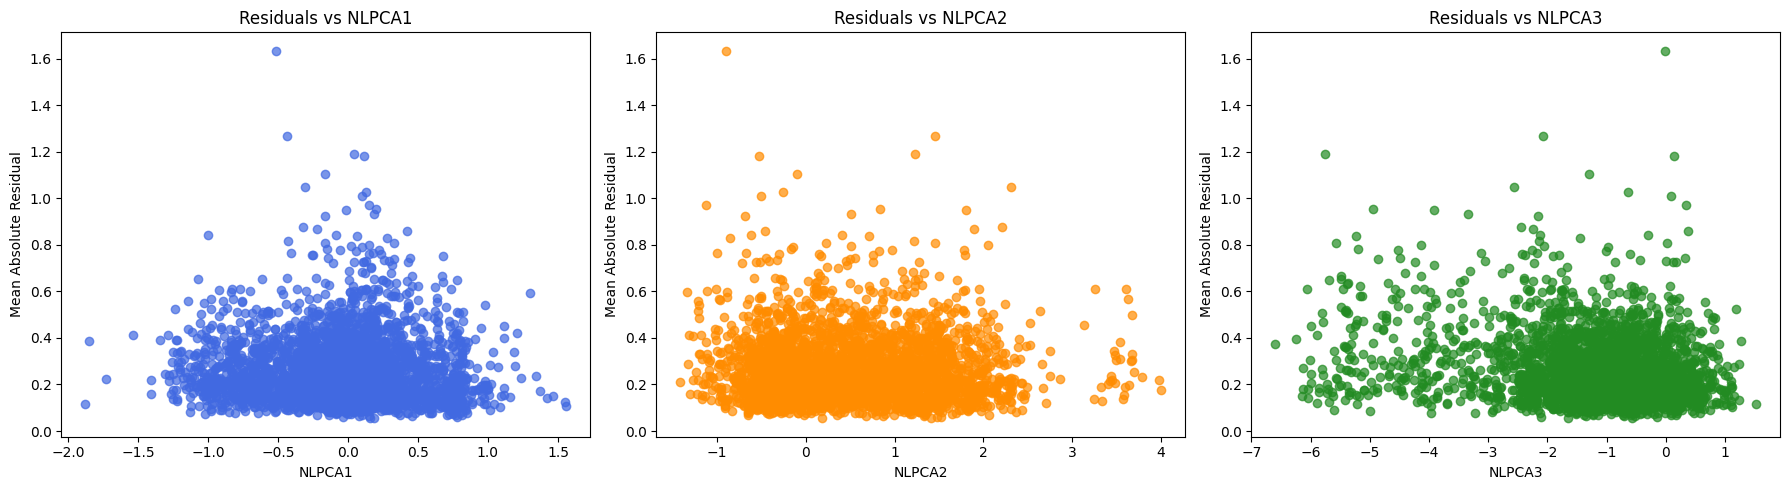

In [ ]:
# Step 1: Predict SA using trained autoencoder
y_pred = autoencoder.predict(X_test, verbose=0)

# Step 2: Compute residuals (Mean Absolute Error per test sample)
residuals = y_test - y_pred  # shape: (num_samples, num_outputs)
mae_per_sample = np.mean(np.abs(residuals), axis=1)  # shape: (num_samples,)

# Step 3: Extract NLPCA components (from encoder applied to X_test)
X_test_nlpca = encoder.predict(X_test, verbose=0)
pca1 = X_test_nlpca[:, 0]
pca2 = X_test_nlpca[:, 1]
pca3 = X_test_nlpca[:, 2]

# Step 4: Plot Residuals vs NLPCA components
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].scatter(pca1, mae_per_sample, alpha=0.7, color='royalblue')
axs[0].set_title('Residuals vs NLPCA1')
axs[0].set_xlabel('NLPCA1')
axs[0].set_ylabel('Mean Absolute Residual')

axs[1].scatter(pca2, mae_per_sample, alpha=0.7, color='darkorange')
axs[1].set_title('Residuals vs NLPCA2')
axs[1].set_xlabel('NLPCA2')
axs[1].set_ylabel('Mean Absolute Residual')

axs[2].scatter(pca3, mae_per_sample, alpha=0.7, color='forestgreen')
axs[2].set_title('Residuals vs NLPCA3')
axs[2].set_xlabel('NLPCA3')
axs[2].set_ylabel('Mean Absolute Residual')

plt.tight_layout()
plt.show()


# 4) Regression Plots

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Overall Test R² Score: 0.8726


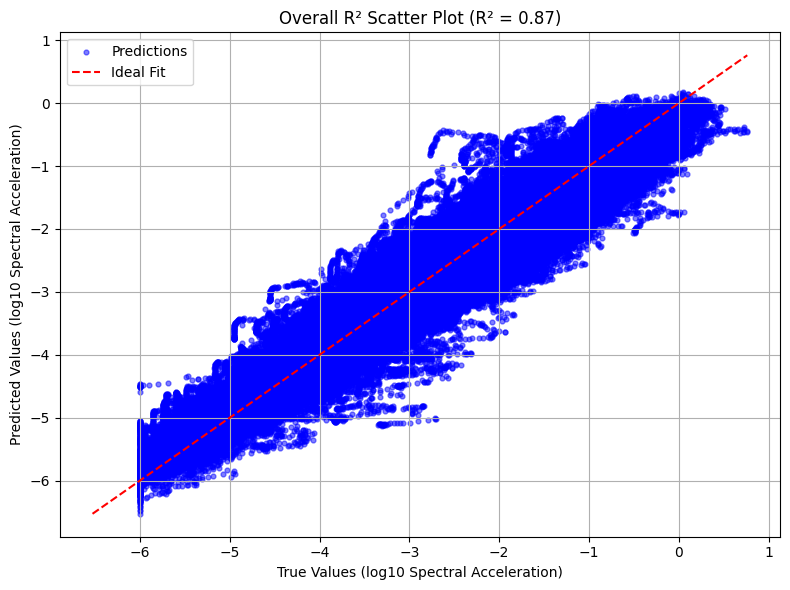

In [ ]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Step 1: Predict using the trained autoencoder
y_pred = autoencoder.predict(X_test)

# Step 2: Calculate overall R² score
overall_r2_test = r2_score(y_test, y_pred, multioutput='uniform_average')
print(f"\nOverall Test R² Score: {overall_r2_test:.4f}")

# Step 3: R² Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test.flatten(), y_pred.flatten(), color='blue', alpha=0.5, s=12, label='Predictions')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')

plt.xlabel("True Values (log10 Spectral Acceleration)")
plt.ylabel("Predicted Values (log10 Spectral Acceleration)")
plt.title(f"Overall R² Scatter Plot (R² = {overall_r2_test:.2f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5) Ground Motion Physics

5.1- PCA vs Timeperiod

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
SA vs Time Period (Varying Magnitude) | mag = 4.0 | Flag: Intra → R²: -2.1165, MSE: 2.4141e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
SA vs Time Period (Varying Magnitude) | mag = 5.0 | Flag: Intra → R²: 0.4393, MSE: 4.3431e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
SA vs Time Period (Varying Magnitude) | mag = 6.0 | Flag: Intra → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
SA vs Time Period (Varying Magnitude) | mag = 7.0 | Flag: Intra → R²: -0.3414, MSE: 1.0390e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
SA vs Time Period (Varying Magnitude) | mag = 8.0 | Flag: Intra → R²: -1.4980, MSE: 1.9350e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
SA vs Time Period (Varying Magnit

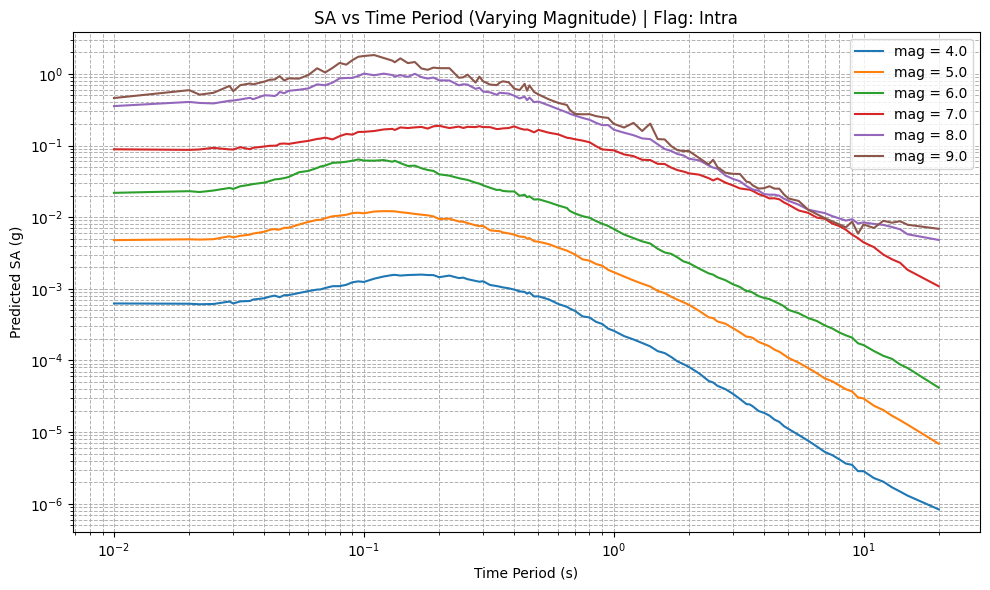

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
SA vs Time Period (Varying Rjb) | rjb = 1 | Flag: Intra → R²: 0.5591, MSE: 3.4156e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
SA vs Time Period (Varying Rjb) | rjb = 10 | Flag: Intra → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
SA vs Time Period (Varying Rjb) | rjb = 30 | Flag: Intra → R²: 0.9699, MSE: 2.3293e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
SA vs Time Period (Varying Rjb) | rjb = 50 | Flag: Intra → R²: 0.8862, MSE: 8.8135e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
SA vs Time Period (Varying Rjb) | rjb = 100 | Flag: Intra → R²: 0.3073, MSE: 5.3661e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
SA vs Time Period (Varying Rjb) | rjb = 1000 | Flag: Intra → R²: -10.54

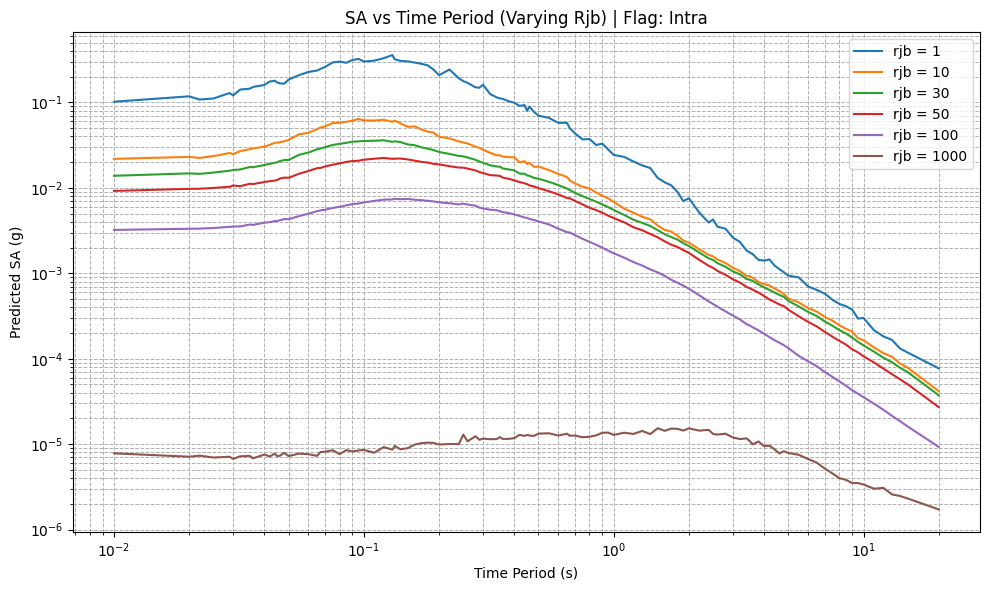

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
SA vs Time Period (Varying VS30) | vs30 = 180 | Flag: Intra → R²: 0.1372, MSE: 6.6837e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
SA vs Time Period (Varying VS30) | vs30 = 360 | Flag: Intra → R²: 0.6857, MSE: 2.4349e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
SA vs Time Period (Varying VS30) | vs30 = 500 | Flag: Intra → R²: 0.9399, MSE: 4.6579e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
SA vs Time Period (Varying VS30) | vs30 = 760 | Flag: Intra → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
SA vs Time Period (Varying VS30) | vs30 = 1000 | Flag: Intra → R²: 0.9946, MSE: 4.1537e-03


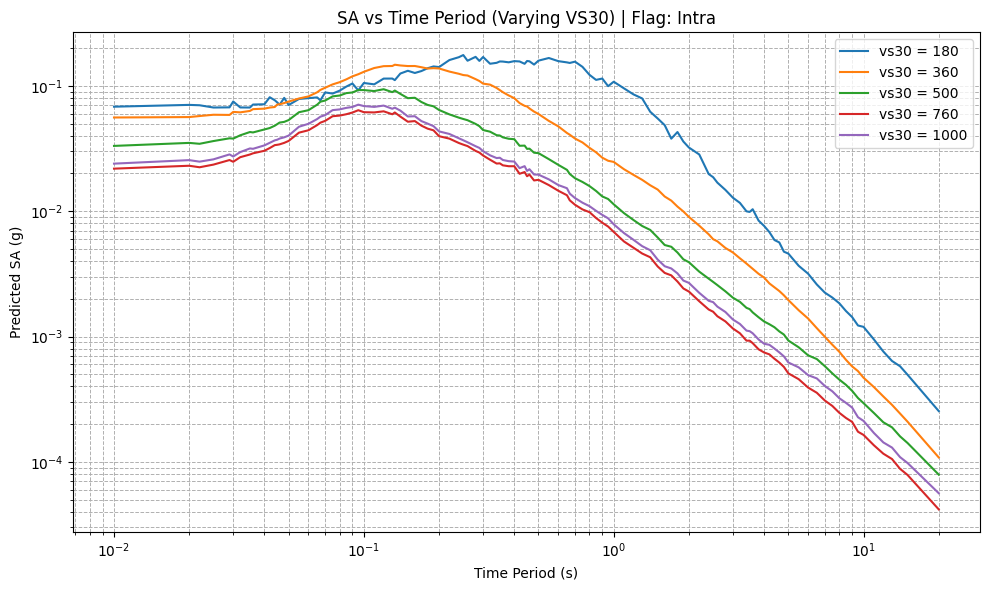

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
SA vs Time Period (Varying Magnitude) | mag = 4.0 | Flag: Inter → R²: -2.1165, MSE: 2.4141e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
SA vs Time Period (Varying Magnitude) | mag = 5.0 | Flag: Inter → R²: 0.4393, MSE: 4.3431e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
SA vs Time Period (Varying Magnitude) | mag = 6.0 | Flag: Inter → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
SA vs Time Period (Varying Magnitude) | mag = 7.0 | Flag: Inter → R²: -0.3414, MSE: 1.0390e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
SA vs Time Period (Varying Magnitude) | mag = 8.0 | Flag: Inter → R²: -1.4980, MSE: 1.9350e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SA vs Time Period (Varying Magnit

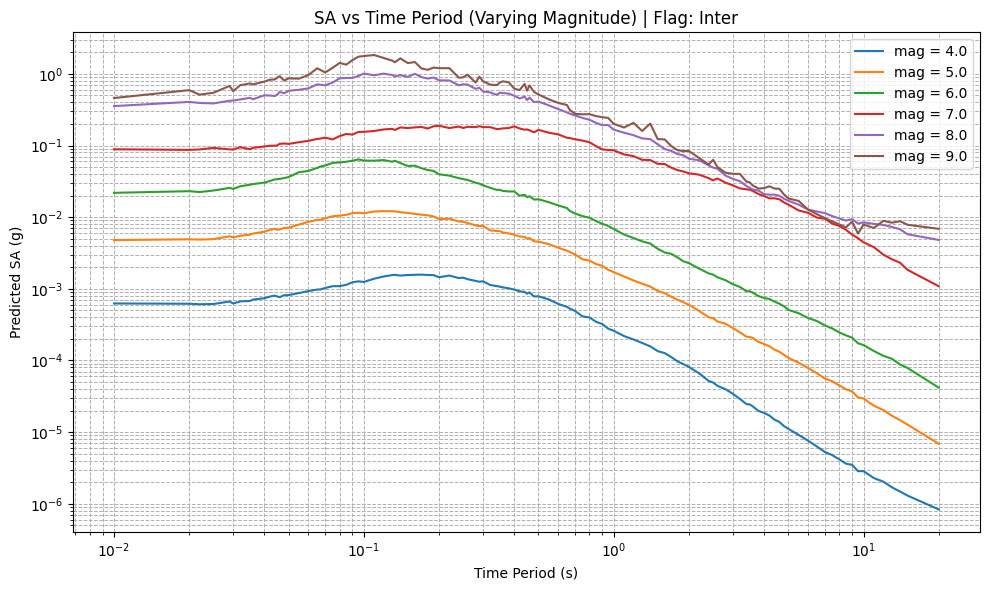

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SA vs Time Period (Varying Rjb) | rjb = 1 | Flag: Inter → R²: 0.5591, MSE: 3.4156e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
SA vs Time Period (Varying Rjb) | rjb = 10 | Flag: Inter → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
SA vs Time Period (Varying Rjb) | rjb = 30 | Flag: Inter → R²: 0.9699, MSE: 2.3293e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
SA vs Time Period (Varying Rjb) | rjb = 50 | Flag: Inter → R²: 0.8862, MSE: 8.8135e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SA vs Time Period (Varying Rjb) | rjb = 100 | Flag: Inter → R²: 0.3073, MSE: 5.3661e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
SA vs Time Period (Varying Rjb) | rjb = 1000 | Flag: Inter → R²: -10.54

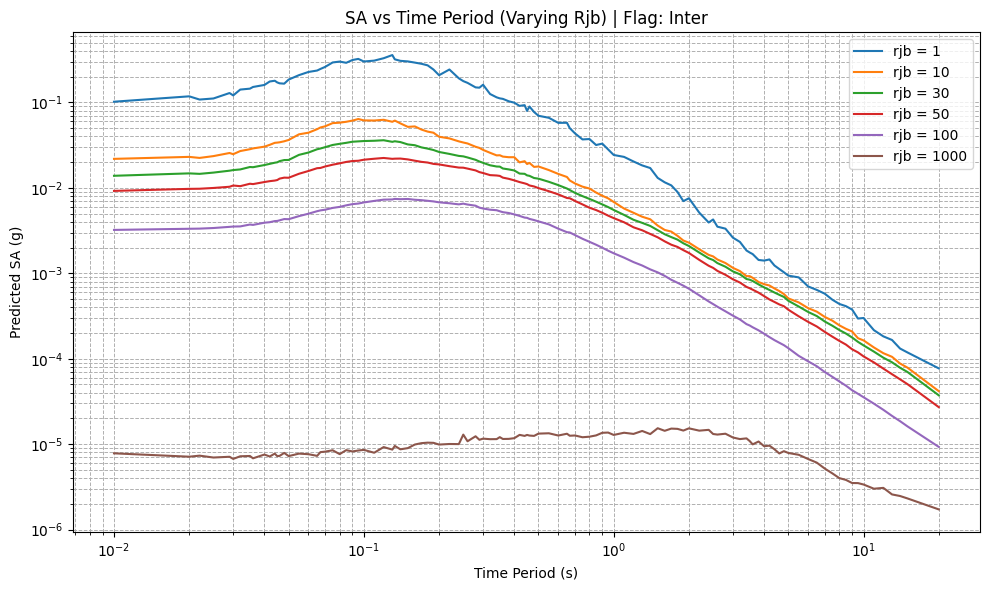

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SA vs Time Period (Varying VS30) | vs30 = 180 | Flag: Inter → R²: 0.1372, MSE: 6.6837e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
SA vs Time Period (Varying VS30) | vs30 = 360 | Flag: Inter → R²: 0.6857, MSE: 2.4349e-01
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
SA vs Time Period (Varying VS30) | vs30 = 500 | Flag: Inter → R²: 0.9399, MSE: 4.6579e-02
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
SA vs Time Period (Varying VS30) | vs30 = 760 | Flag: Inter → R²: 1.0000, MSE: 0.0000e+00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
SA vs Time Period (Varying VS30) | vs30 = 1000 | Flag: Inter → R²: 0.9946, MSE: 4.1537e-03


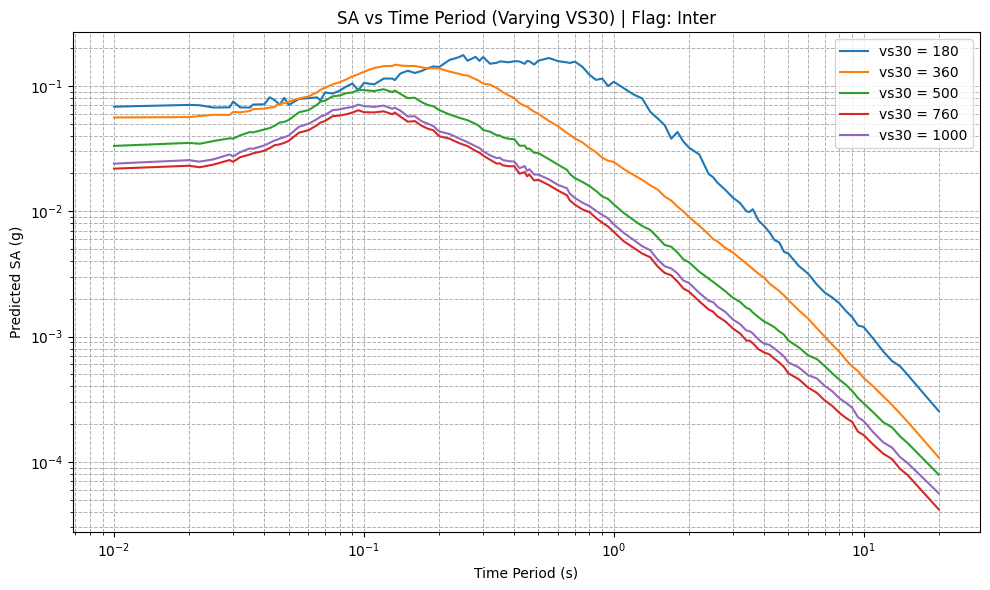

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Convert column names to time periods
time_periods = [float(col.replace('T', '').replace('pt', '.').replace('S', '')) for col in output_cols]

# Use a different name for sklearn encoder to avoid conflict with Keras model
flag_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = flag_encoder.fit_transform(df[['intra_inter']])
encoded_df = pd.DataFrame(encoded, columns=flag_encoder.get_feature_names_out(['intra_inter']))

X = df[input_features].drop(columns=['intra_inter']).reset_index(drop=True)
X = pd.concat([X, encoded_df.reset_index(drop=True)], axis=1)
X = X.values

# Re-train/test split and scale (preserved)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Autoencoder
def build_autoencoder(input_dim, bottleneck_dim=3):
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense

    input_layer = Input(shape=(input_dim,))
    x = Dense(64, activation='relu')(input_layer)
    x = Dense(32, activation='relu')(x)
    bottleneck = Dense(bottleneck_dim, activation='linear', name='bottleneck')(x)
    encoder_model = Model(inputs=input_layer, outputs=bottleneck)

    encoded_input = Input(shape=(bottleneck_dim,))
    y = Dense(32, activation='relu')(encoded_input)
    y = Dense(64, activation='relu')(y)
    output_layer = Dense(y_train.shape[1], activation='linear')(y)
    decoder_model = Model(inputs=encoded_input, outputs=output_layer)

    auto_output = decoder_model(encoder_model(input_layer))
    autoencoder = Model(inputs=input_layer, outputs=auto_output)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder_model, decoder_model

autoencoder, encoder_model, decoder_model = build_autoencoder(X_train.shape[1])
autoencoder.fit(X_train, y_train, validation_split=0.2,
                epochs=100, batch_size=16, verbose=0,
                callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

# === Prediction Function ===
def predict_for_varied_input_nlpca(variable_name, variable_values, title, flag_value):
    # One-hot encode the flag using correct sklearn encoder
    encoded_flag = flag_encoder.transform([[flag_value]])[0]

    predictions = []

    # Default input values
    default_input = np.array([
        6.0,    # mag
        10.0,   # rjb
        np.log10(10.0),
        np.log10(760.0),
    ])
    default_full_input = np.concatenate([default_input, encoded_flag])
    default_scaled = scaler.transform([default_full_input])
    encoded_default = encoder_model.predict(default_scaled)
    y_ref = decoder_model.predict(encoded_default)[0]

    # Plotting
    plt.figure(figsize=(10, 6))

    for value in variable_values:
        input_sample = {'mag': 6.0, 'rjb': 10.0, 'vs30': 760.0}
        input_sample[variable_name] = value

        logrjb = np.log10(input_sample['rjb'])
        logvs30 = np.log10(input_sample['vs30'])

        input_array = np.array([
            input_sample['mag'],
            input_sample['rjb'],
            logrjb,
            logvs30,
        ])
        full_input = np.concatenate([input_array, encoded_flag])
        full_input_scaled = scaler.transform([full_input])
        encoded = encoder_model.predict(full_input_scaled)
        y_pred = decoder_model.predict(encoded)[0]

        predictions.append(y_pred)

        r2 = r2_score(y_ref, y_pred)
        mse = mean_squared_error(y_ref, y_pred)
        print(f"{title} | {variable_name} = {value} | Flag: {flag_value} → R²: {r2:.4f}, MSE: {mse:.4e}")

        plt.plot(time_periods, 10**y_pred, label=f'{variable_name} = {value}')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("Time Period (s)")
    plt.ylabel("Predicted SA (g)")
    plt.title(f"{title} | Flag: {flag_value}")
    plt.legend()
    plt.grid(True, which="both", ls="--", linewidth=0.7)
    plt.tight_layout()
    plt.show()

# === Run for 'Intra' and 'Inter' ===
for flag in ['Intra', 'Inter']:
    predict_for_varied_input_nlpca('mag', np.arange(4.0, 9.1, 1.0), "SA vs Time Period (Varying Magnitude)", flag)
    predict_for_varied_input_nlpca('rjb', [1, 10, 30, 50, 100, 1000], "SA vs Time Period (Varying Rjb)", flag)
    predict_for_varied_input_nlpca('vs30', [180, 360, 500, 760, 1000], "SA vs Time Period (Varying VS30)", flag)


5.2- PCA vs Rjb( distance)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but OneHotEncoder was fitted with feature names



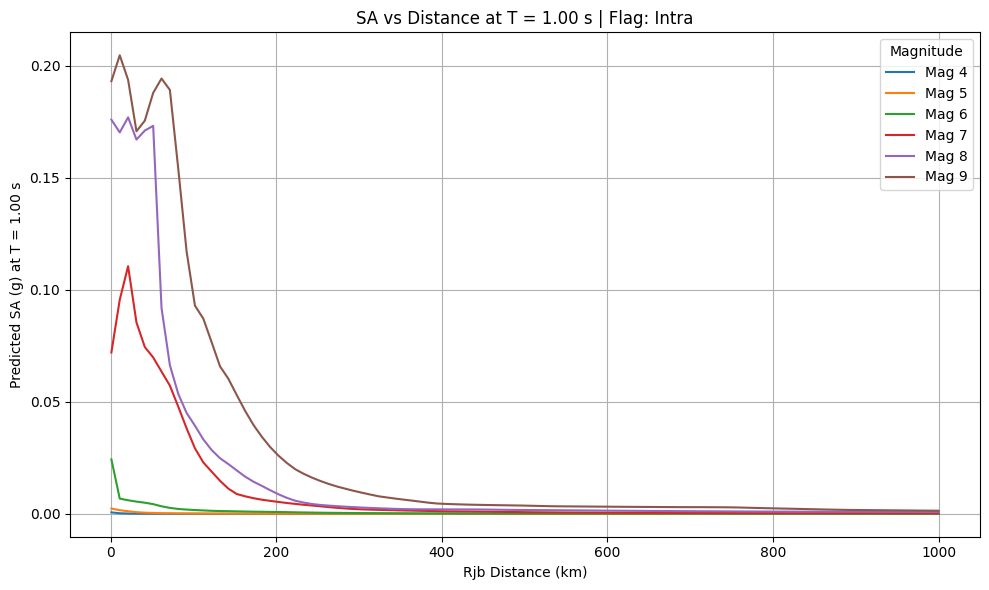

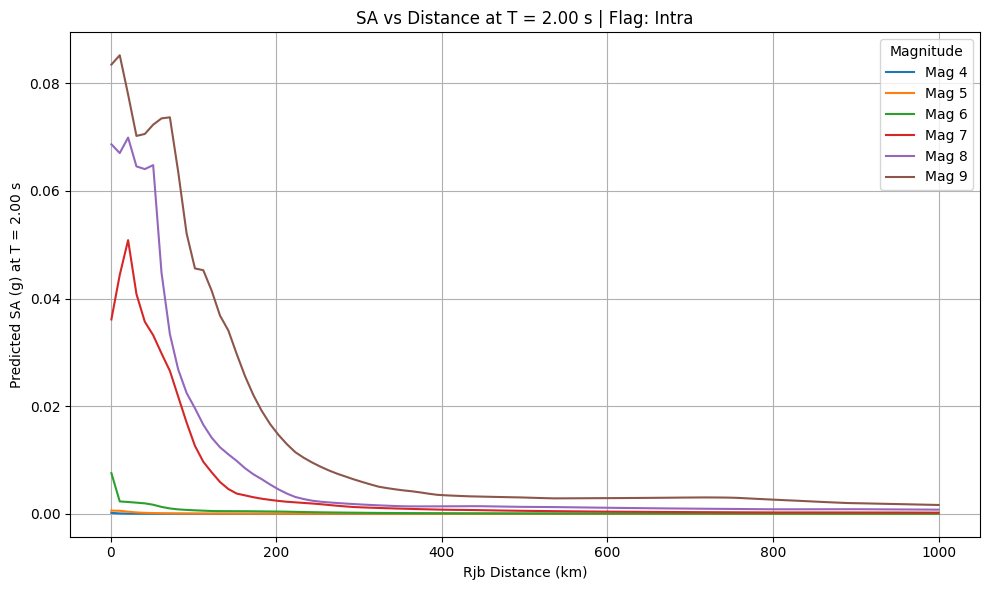

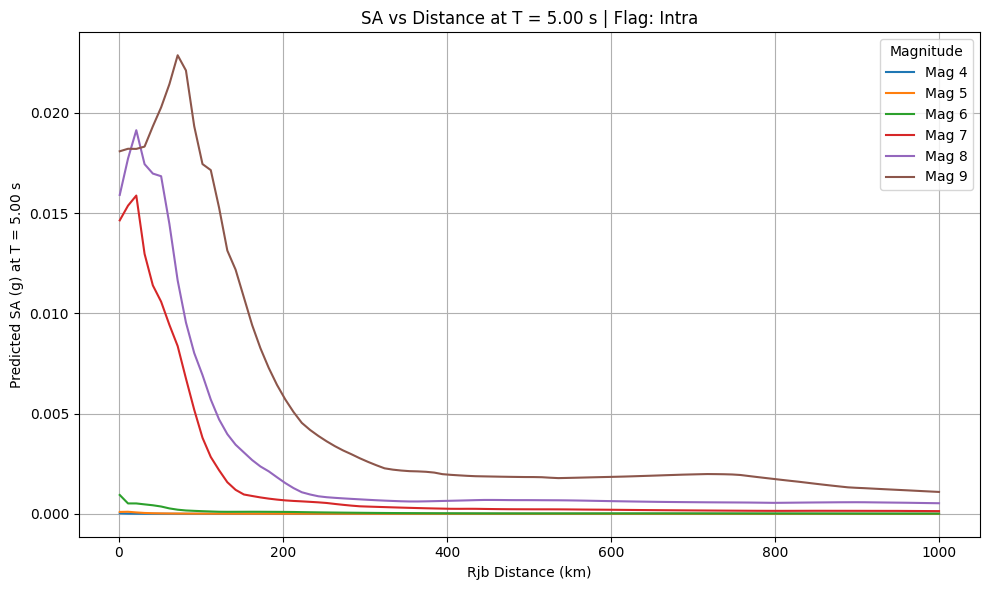

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Configuration ---
const_Ztor = 5.0  # still unused
const_VS30 = 760.0
const_flag = 'Intra'  # or 'Inter'

magnitudes = np.arange(4.0, 10.0, 1.0)   # 4.0 to 9.0
rjb_values = np.linspace(1, 1000, 100)   # 100 points from 1 km to 1000 km

# Map time periods to column names
time_periods = [float(c.replace('T', '').replace('pt', '.').replace('S', '')) for c in output_cols]
tp_to_col = dict(zip(time_periods, output_cols))

# Select specific periods to plot
selected_periods = [1, 2, 5]
periods = [tp for tp in selected_periods if tp in tp_to_col]

# Encode the flag correctly using sklearn's OneHotEncoder
encoded_flag = flag_encoder.transform([[const_flag]])[0]

# --- Plotting Loop ---
for tp in periods:
    col = tp_to_col[tp]  # e.g., 'T1pt000S'
    plt.figure(figsize=(10, 6))

    for mag in magnitudes:
        sa_preds = []
        for rjb in rjb_values:
            logrjb = np.log10(rjb)
            logvs30 = np.log10(const_VS30)

            input_vector = np.array([
                mag,
                rjb,
                logrjb,
                logvs30,
                *encoded_flag
            ]).reshape(1, -1)

            # Scale input
            input_scaled = scaler.transform(input_vector)

            # NLPCA Prediction
            latent_code = encoder_model.predict(input_scaled, verbose=0)
            decoded_output = decoder_model.predict(latent_code, verbose=0)

            # Get log10(SA) for the selected time period and convert to SA (g)
            sa_log10 = decoded_output[0, output_cols.index(col)]
            sa = 10 ** sa_log10
            sa_preds.append(sa)

        # Plot SA vs Rjb for current magnitude
        plt.plot(rjb_values, sa_preds, label=f'Mag {mag:.0f}')

    plt.xlabel("Rjb Distance (km)")
    plt.ylabel(f"Predicted SA (g) at T = {tp:.2f} s")
    plt.title(f"SA vs Distance at T = {tp:.2f} s | Flag: {const_flag}")
    plt.legend(title="Magnitude")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# 6) Error bar Plots

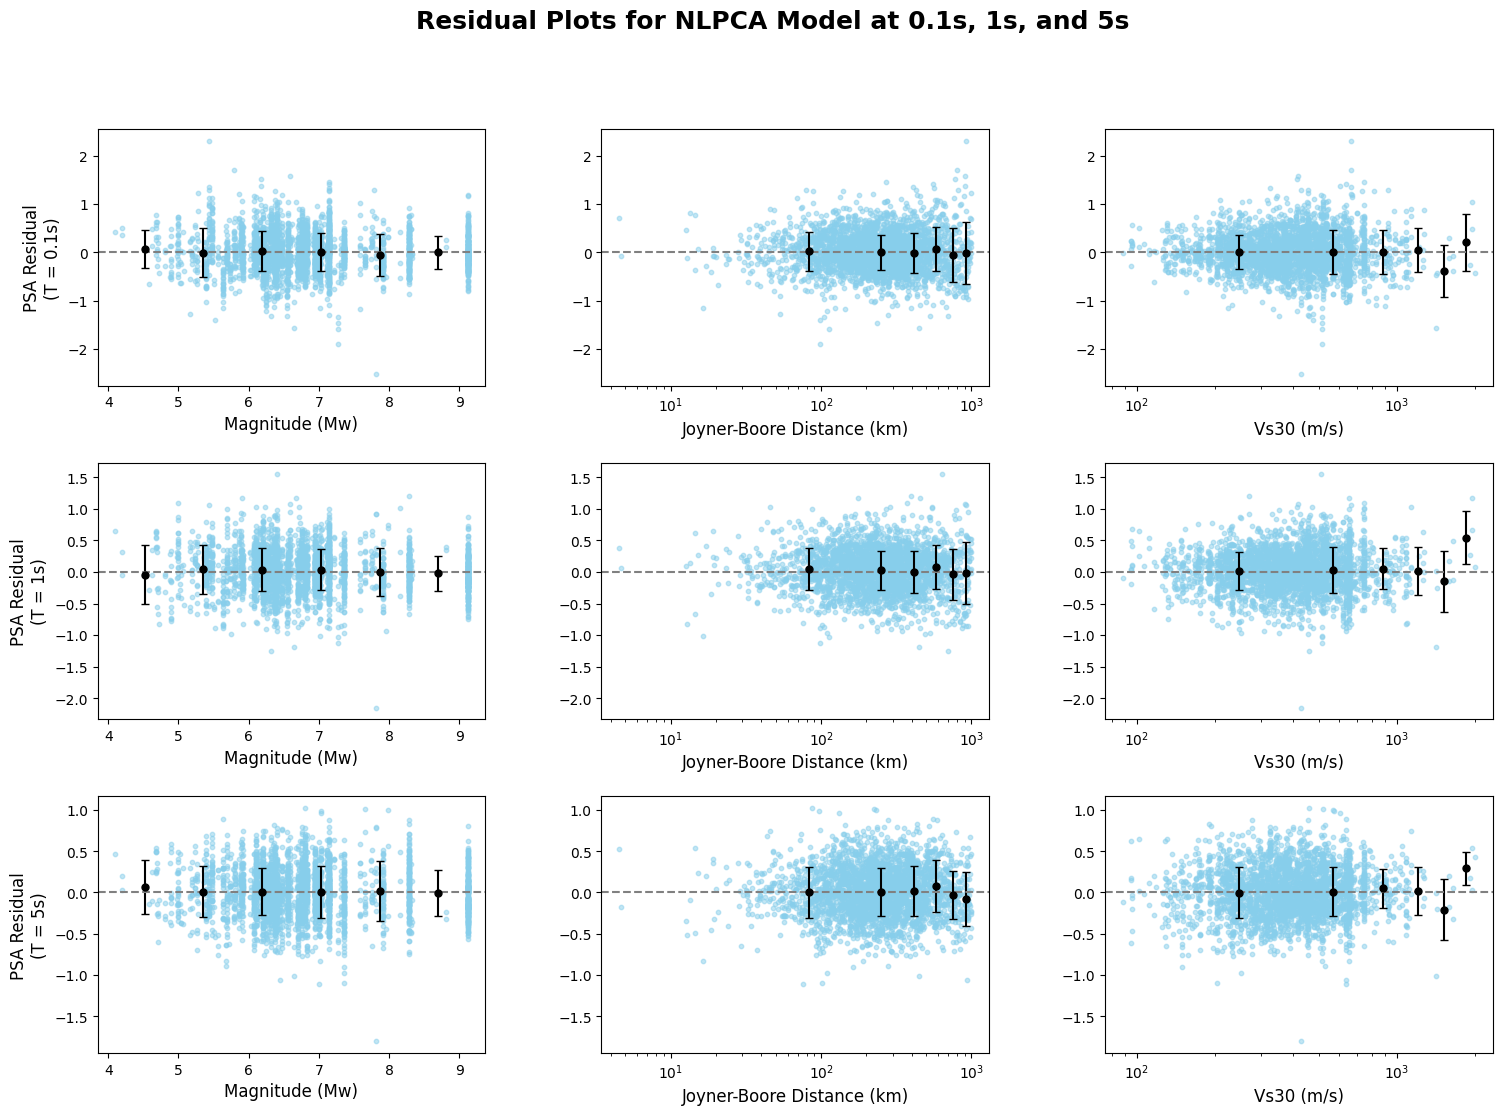

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic

# Step 1: Predict using trained encoder-decoder (NLPCA) model
latent_codes = encoder_model.predict(X_test, verbose=0)
y_pred = decoder_model.predict(latent_codes, verbose=0)

# Step 2: Define periods and corresponding output column names
period_columns = {
    0.1: "T0pt100S",   # 0.1 second
    1:   "T1pt000S",   # 1 second
    5:   "T5pt000S"    # 5 second
}

# Step 3: Inverse-transform X_test to get raw input features
X_test_inv = scaler.inverse_transform(X_test)

# Step 4: Original input feature names
input_features = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter_0', 'intra_inter_1']

# Step 5: Prepare for residual plots
features = ['mag', 'rjb', 'vs30']
feature_labels = ['Magnitude (Mw)', 'Joyner-Boore Distance (km)', 'Vs30 (m/s)']

# Step 6: Recover original features from transformed ones
mag_values = X_test_inv[:, input_features.index('mag')]
rjb_values = X_test_inv[:, input_features.index('rjb')]
vs30_values = 10 ** X_test_inv[:, input_features.index('logvs30')]

X_test_raw = np.vstack([mag_values, rjb_values, vs30_values]).T  # shape (n_samples, 3)

# Step 7: Plotting residuals
fig, axes = plt.subplots(len(period_columns), len(features), figsize=(18, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i, (period, col_name) in enumerate(period_columns.items()):
    col_idx = output_cols.index(col_name)

    # Compute residuals: true - predicted (still in log10 units)
    residuals = y_test[:, col_idx] - y_pred[:, col_idx]

    for j, feature in enumerate(features):
        ax = axes[i, j]

        x_vals = X_test_raw[:, j]

        # Scatter plot
        ax.scatter(x_vals, residuals, color='skyblue', alpha=0.5, s=10)

        # Binned mean and std
        bin_means, bin_edges, _ = binned_statistic(x_vals, residuals, statistic='mean', bins=6)
        bin_stds, _, _ = binned_statistic(x_vals, residuals, statistic='std', bins=6)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Error bars
        ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black',
                    ecolor='black', capsize=3, markersize=5)

        # Axis and formatting
        ax.axhline(0, color='gray', linestyle='--')
        ax.set_xlabel(feature_labels[j], fontsize=12)

        if j == 0:
            ax.set_ylabel(f'PSA Residual\n(T = {period}s)', fontsize=12)

        if feature in ['rjb', 'vs30']:
            ax.set_xscale('log')

plt.suptitle('Residual Plots for NLPCA Model at 0.1s, 1s, and 5s', fontsize=18, fontweight='bold')
plt.show()


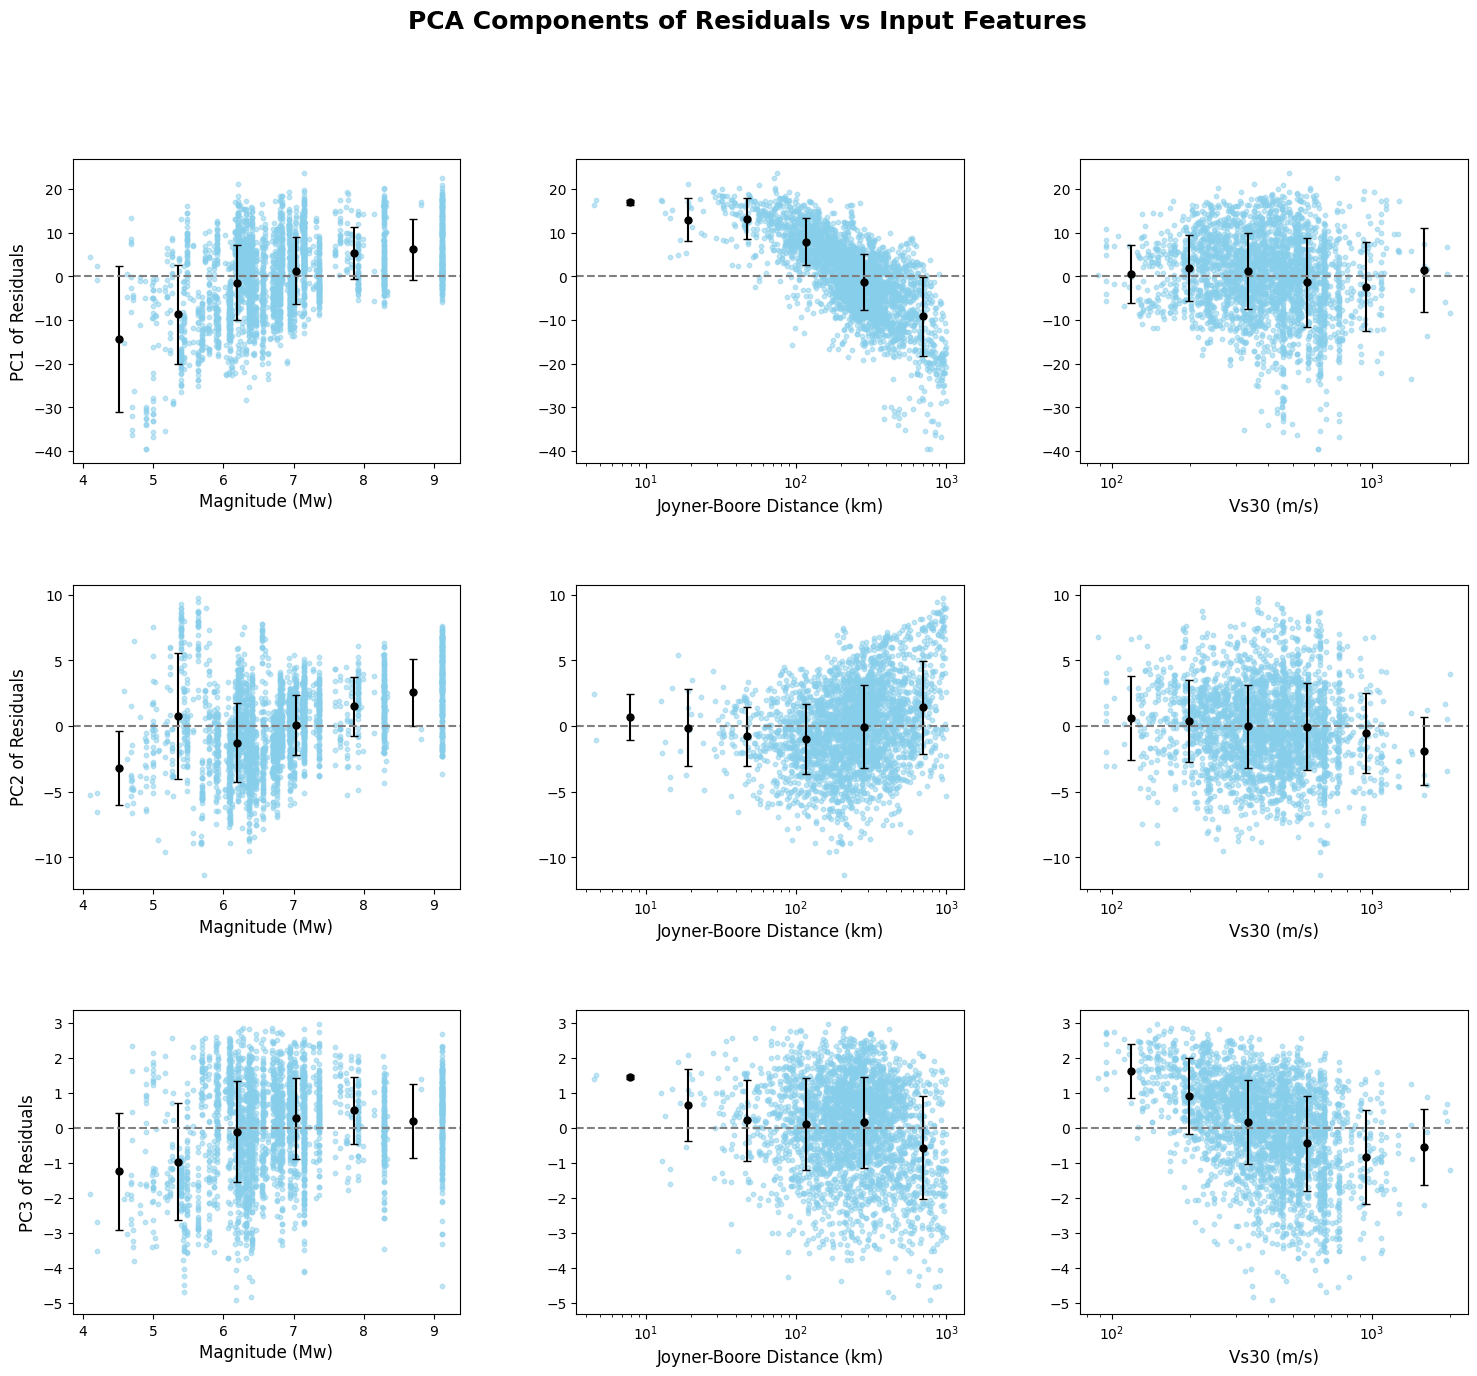

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from sklearn.decomposition import PCA

# Step 1: Predict using trained encoder-decoder (NLPCA) model
latent_codes = encoder.predict(X_test, verbose=0)
y_pred = decoder_model.predict(latent_codes, verbose=0)

# Step 2: Compute residuals (true - predicted)
residuals = y_test - y_pred  # Already in log10 space

# Step 3: Perform PCA on residuals
pca = PCA(n_components=3)
pca_components = pca.fit_transform(residuals)
pc_labels = ['PC1', 'PC2', 'PC3']

# Step 4: Get original input features
X_test_inv = scaler.inverse_transform(X_test)
mag_values = X_test_inv[:, 0]  # Magnitude
rjb_values = X_test_inv[:, 1]  # Joyner-Boore distance (km)
vs30_values = 10 ** X_test_inv[:, 3]  # Vs30 (m/s) - converting from log10

# Step 5: Create figure
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Features to plot against
features = [mag_values, rjb_values, vs30_values]
feature_labels = ['Magnitude (Mw)', 'Joyner-Boore Distance (km)', 'Vs30 (m/s)']
log_flags = [False, True, True]  # Which features should use log scale

# Step 6: Plot each PC against each feature
for i in range(3):  # For each PC (PC1, PC2, PC3)
    for j in range(3):  # For each feature (mag, rjb, vs30)
        ax = axes[i, j]
        x_vals = features[j]
        y_vals = pca_components[:, i]

        # Scatter plot
        ax.scatter(x_vals, y_vals, color='skyblue', alpha=0.5, s=10)

        # Binned statistics
        if log_flags[j]:
            # Ensure x_vals are positive for log scale
            x_vals_positive = x_vals[x_vals > 0]
            y_vals_positive = y_vals[x_vals > 0]  # Select corresponding y_vals

            bins = np.logspace(np.log10(x_vals_positive.min()), np.log10(x_vals_positive.max()), 7)

            # Calculate binned statistics using positive values
            bin_means, bin_edges, _ = binned_statistic(x_vals_positive, y_vals_positive, statistic='mean', bins=bins)
            bin_stds, _, _ = binned_statistic(x_vals_positive, y_vals_positive, statistic='std', bins=bins)

        else:
            bins = np.linspace(x_vals.min(), x_vals.max(), 7)

            bin_means, bin_edges, _ = binned_statistic(x_vals, y_vals, statistic='mean', bins=bins)
            bin_stds, _, _ = binned_statistic(x_vals, y_vals, statistic='std', bins=bins)

        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Error bars
        ax.errorbar(bin_centers, bin_means, yerr=bin_stds, fmt='o', color='black',
                   ecolor='black', capsize=3, markersize=5)

        # Formatting
        ax.axhline(0, color='gray', linestyle='--')
        ax.set_xlabel(feature_labels[j], fontsize=12)
        if j == 0:
            ax.set_ylabel(f'{pc_labels[i]} of Residuals', fontsize=12)
        if log_flags[j]:
            ax.set_xscale('log')

plt.suptitle('PCA Components of Residuals vs Input Features', fontsize=18, fontweight='bold')
plt.show()

# 7) Relative inportance plots

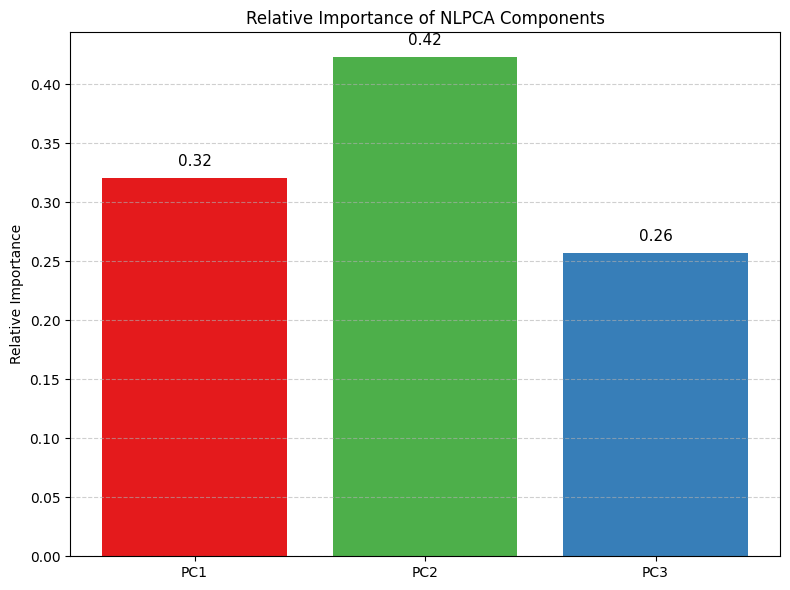

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define Latent Space Perturbations ---
base_point = np.zeros((1, 3))  # Center of latent space
delta = 0.05                   # Small perturbation value

# Create perturbed latent points along each principal component
perturbations = []
labels = []

for i in range(3):  # For PC1, PC2, PC3
    for direction in [-1, 1]:
        pert = np.zeros((1, 3))
        pert[0, i] = direction * delta
        perturbations.append(base_point + pert)
        labels.append(f'PC{i+1} {"+" if direction > 0 else "-"}')

perturbations = np.vstack(perturbations)  # Shape (6, 3)

# --- Step 2: Decode the Perturbed Latents ---
decoded_outputs = decoder_model.predict(perturbations, verbose=0)  # (6, n_outputs)
base_output = decoder_model.predict(base_point, verbose=0)         # (1, n_outputs)

# --- Step 3: Calculate Sensitivity for Each PC ---
diffs = np.abs(decoded_outputs - base_output)  # (6, n_outputs)

avg_diff_per_pc = []
for i in range(3):
    # Average of both +delta and -delta deviations
    avg_diff = (diffs[i * 2] + diffs[i * 2 + 1]) / 2
    avg_diff_per_pc.append(avg_diff)

avg_diff_per_pc = np.array(avg_diff_per_pc)  # Shape (3, n_outputs)

# --- Step 4: Aggregate and Normalize Importance ---
relative_importance = np.mean(avg_diff_per_pc, axis=1)
relative_importance /= np.sum(relative_importance)  # Normalize to 1

# --- Step 5: Plot Component Importance ---
plt.figure(figsize=(8, 6))
bars = plt.bar(['PC1', 'PC2', 'PC3'], relative_importance, color=['#e41a1c', '#4daf4a', '#377eb8'])

# Annotate bar values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=11)

plt.ylabel('Relative Importance')
plt.title('Relative Importance of NLPCA Components')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


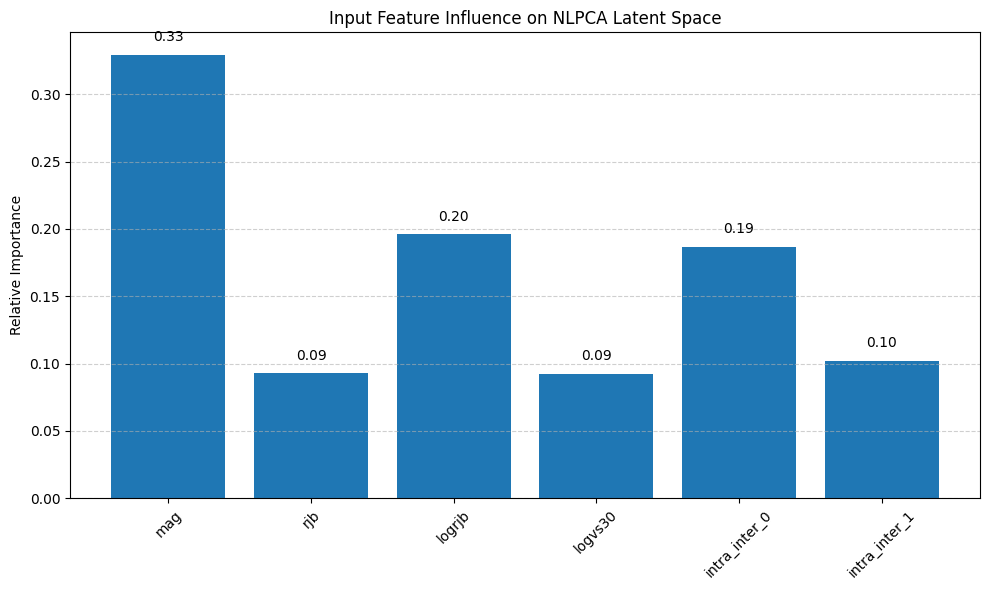

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define a Base Input ---
base_input = np.mean(X_train, axis=0, keepdims=True)  # Mean of training data
delta = 0.05  # Perturbation size

# --- Step 2: Perturb Each Input Feature (+/- delta) ---
perturbations = []
labels = []

n_features = base_input.shape[1]

for i in range(n_features):
    for direction in [-1, 1]:
        pert = np.copy(base_input)
        pert[0, i] += direction * delta
        perturbations.append(pert)
        labels.append(f'Feature {i+1} {"+" if direction > 0 else "-"}')

perturbations = np.vstack(perturbations)  # Shape: (2 * n_features, n_features)

# --- Step 3: Encode with NLPCA Encoder ---
encoded_outputs = encoder_model.predict(perturbations, verbose=0)  # Shape: (2 * n_features, 3)
base_encoded = encoder_model.predict(base_input, verbose=0)       # Shape: (1, 3)

# --- Step 4: Measure Sensitivity (L2 Norm per feature) ---
diffs = np.abs(encoded_outputs - base_encoded)

avg_diff_per_input = []
for i in range(n_features):
    diff_neg = diffs[i * 2]
    diff_pos = diffs[i * 2 + 1]
    avg_diff = (diff_neg + diff_pos) / 2
    avg_diff_per_input.append(np.linalg.norm(avg_diff))  # L2 norm of latent space shift

avg_diff_per_input = np.array(avg_diff_per_input)

# --- Step 5: Normalize to Get Relative Importance ---
relative_importance = avg_diff_per_input / np.sum(avg_diff_per_input)

# --- Step 6: Plot ---
input_names = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter_0', 'intra_inter_1']

plt.figure(figsize=(10, 6))
bars = plt.bar(input_names, relative_importance, color='#1f77b4')

# Annotate values on top
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', fontsize=10)

plt.xticks(rotation=45)
plt.ylabel('Relative Importance')
plt.title('Input Feature Influence on NLPCA Latent Space')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# 8) SHAP analysis

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Randomly selected PSA time period index: 44
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


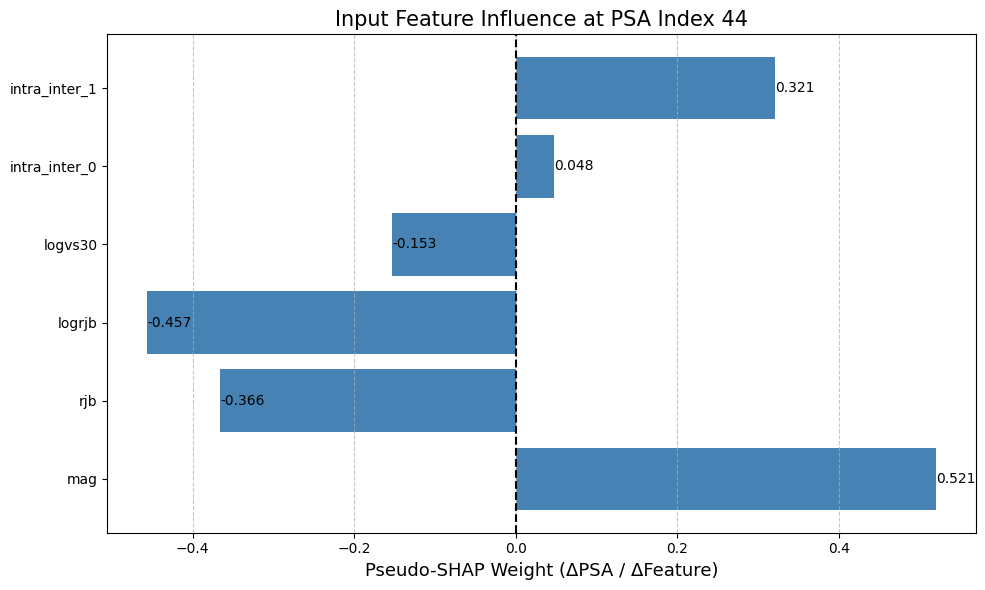

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Step 1: Define input feature names manually (known input structure) ---
input_cols = ['mag', 'rjb', 'logrjb', 'logvs30', 'intra_inter_0', 'intra_inter_1']

# --- Step 2: Predict using NLPCA Autoencoder ---
y_pred = autoencoder.predict(X_test)

# --- Step 3: Choose a random PSA output column index ---
time_indices = np.arange(y_pred.shape[1])  # indices: 0, 1, ..., N
random_period_idx = np.random.choice(time_indices)

print(f"Randomly selected PSA time period index: {random_period_idx}")

# --- Step 4: Pseudo-SHAP Calculation ---
epsilon = 1e-2  # Small input shift
feature_importances = []

for feature_idx in range(len(input_cols)):
    X_perturbed = X_test.copy()
    X_perturbed[:, feature_idx] += epsilon

    # Predict after perturbation
    y_pred_perturbed = autoencoder.predict(X_perturbed)

    # Approximate local gradient at selected output
    delta_mean = y_pred_perturbed[:, random_period_idx].mean() - y_pred[:, random_period_idx].mean()
    feature_importances.append(delta_mean / epsilon)

feature_importances = np.array(feature_importances)

# --- Step 5: Plot Pseudo-SHAP Style Attribution ---
plt.figure(figsize=(10, 6))
bars = plt.barh(input_cols, feature_importances, color='steelblue')

# Annotate values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.3f}', va='center', ha='left', fontsize=10)

plt.axvline(0, color='black', linestyle='--')
plt.xlabel("Pseudo-SHAP Weight (ΔPSA / ΔFeature)", fontsize=13)
plt.title(f"Input Feature Influence at PSA Index {random_period_idx}", fontsize=15)
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#TABLES

In [ ]:
results = []
y_pred_all = autoencoder.predict(X_test)  # Predict outside the loop to keep original shape

EqId_test = df.loc[X_test_orig_df.index, 'eid']

for i, col in enumerate(output_cols):
    y_true = y_pred_all[:, i]
    y_pred = y_pred_all[:, i]
    residuals = y_true - y_pred

    temp_df = pd.DataFrame({
        'event': EqId_test,  # Use event IDs for test set only
        'residuals': residuals
    })

    event_means = temp_df.groupby('event')['residuals'].mean()
    tau = event_means.std(ddof=0)

    phi_sq_list = []
    for _, group in temp_df.groupby('event'):
        res = group['residuals'].values
        if len(res) > 1:
            phi_sq_list.extend((res - res.mean())**2)
    phi = np.sqrt(np.mean(phi_sq_list))

    r2 = r2_score(y_true, y_pred)
    total = np.sqrt(tau**2 + phi**2)

    results.append({
        'Target Variable': col,
        'R2': r2,
        'Inter-Std (τ)': tau,
        'Intra-Std (φ)': phi,
        'Total Std': total
    })

table02 = pd.DataFrame(results).round(4)
print(table02)

91/91 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
    Target Variable   R2  Inter-Std (τ)  Intra-Std (φ)  Total Std
0          T0pt010S  1.0            0.0            0.0        0.0
1          T0pt020S  1.0            0.0            0.0        0.0
2          T0pt022S  1.0            0.0            0.0        0.0
3          T0pt025S  1.0            0.0            0.0        0.0
4          T0pt029S  1.0            0.0            0.0        0.0
..              ...  ...            ...            ...        ...
106       T12pt000S  1.0            0.0            0.0        0.0
107       T13pt000S  1.0            0.0            0.0        0.0
108       T14pt000S  1.0            0.0            0.0        0.0
109       T15pt000S  1.0            0.0            0.0        0.0
110       T20pt000S  1.0            0.0            0.0        0.0

[111 rows x 5 columns]
